# Retrieving Simulator Logs from Log Analytics for Analysis

This notebook shows you how to access the logs from your simulators, and provides a few sample analyses. Episode level and iteration level logs during training and assessment are stored on [Log Anlytics](https://docs.microsoft.com/en-us/azure/azure-monitor/platform/data-platform-logs). The logs on Azure Monitor can be accessed using the query language [KQL](https://docs.microsoft.com/en-us/sharepoint/dev/general-development/keyword-query-language-kql-syntax-reference). 

The notebook uses the jupyter extension [`Kqlmagic`](https://github.com/Microsoft/jupyter-Kqlmagic), to automatically query the data directly within the notebook. More info + more complete functionality on the ` Kqlmagic` extension is available on its official [docs](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic).

## Description

Simulator logs are enabled by default for brains trained during assessment. For training they must be enabled via the CLI command [bonsai brain version start-logging](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-logging).

## Prerequisites

1. Install requirements: an [enviroment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/) is provided with a complete description of the packages needed to run this notebook using Anaconda. Please install Anaconda (or miniconda) and run `conda env update -f environment.yml` in the folder where you download the linked `environment.yml` file.
2. If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered manually using the azure-cli:
    1. Determine if registering is required. <SUBCRIPTION_ID> can be found on preview.bons.ai by clicking on id/Workspace info. 
    ```
    az provider show --namespace 'Microsoft.OperationalInsights' -o table --subscription <SUBCRIPTION_ID>
    ```
    2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace 'Microsoft.OperationalInsights' --subscription <SUBCRIPTION_ID>
    ```
### Note

A Log Analytics workspace will get created on Azure if it does not already exist in the provisioned Bonsai workspace.
 
## Usage

1. Start a simulator instance for Brain training: 
    1. For managed simulators
        1. Add the simulator instance to your inkling using the `package` statement, or start training and select the simulator instance using the web
        2. _or_ use the CLI: [`bonsai brain version start-training --simulator-package-name`](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-training)
    2. For unmanaged simulators:
        1. register a sim by launching your sim. For example `python main.py`
        2. start brain training `bonsai brain version start-training --name <BRAIN_NAME>`
        3. connect your registered sim to a brain `bonsai simulator unmanaged connect --simulator-name <SIM_NAME> --brain-name <BRAIN_NAME> --version <VERSION_#> --action Train --concept-name <CONCEPT_NAME>`
        4. Find the `session-id` of un-managed sim using Bonsai CLI: `bonsai simulator unmanaged list`
2. Enable logging using the CLI:
    1. For managed simulators, add the `-m` parameter for managed simulator logging and the number of instances to log:
        `bonsai brain version start-logging -m -s <NUM_INSTANCES> -n <BRAIN_NAME>`
        You can also optionally request for system logs with the `-l` parameter.
    2. For unmanaged simulators, you should specify the `session-id`: 
        `bonsai brain version start-logging -n <BRAIN_NAME> --session-id <SESSION_ID>`
3. Logs will start populating the Log Analytics workspace 3-5 minutes after starting logging
4. Obtain your KQL workspace-id by navigating to the KQL resource in the Azure Portal:
    ![log-analytics-azure-portal](log-analytics-id.png)

## Getting Started

### Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statem `%%kql`.

In [15]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

### Login to the log analytics workspace

Retrieve the `LOG_ANALYTICS_WORKSPACE_ID` using the instructions provided above. Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace!


In [16]:
LOG_ANALYTICS_WORKSPACE_ID = "0c26bd37-834f-43ec-80f5-21e8ba6b86bc" 
ALIAS = 'alizaidi' # could be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

<IPython.core.display.Javascript object>

## Iteration and Episode Level Logs

There are four tables generated by the Bonsai service and sent to your Log Analytics workspace. These are:

1. `EpisodeLog_CL` which contains your episode-level logs, such as information about the starting simulator configuration of your episodes, your aggregate goal metrics, etc.
2. `IterationLog_CL` which contains the interation-level logs of your simulator, including the actions received from the platform, and the states emitted from your simulators.
3. `ContainerEvent_CL` (**only for managed simulators that were logged with system logs**): container event logs such as image pull time, build time, etc.
4. `ContainerInstanceLog_CL` (**only for managed simulators that were logged with system logs**): system logs from your simulators.

Let's extract both iteration (`IterationLog_CL`) and episode-level (`EpisodeLog_CL`) logs and join them together via a KQL query. We then export the query results to a pandas dataframe which we can then manipulate and analyze.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level logs are created and filled with at least 1 row of data.

### Specify Query Variables and Query

In order to make our query specific to a brain version and brain name, we can create variables containing those values. The following cell does exactly that, and in addition specific a max number of rows to query.

In [22]:
number_of_rows = 1000
brain_name = "poleonacart"
brain_version = 1

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` table to the brain name and brain version we defined above, and then join it with the `IterationLog_CL` table using the unique `EpisodeId_g` index. Finally, we select (using `project`) a set of columns we want to retain in our resulting dataframe.

In [23]:
%%kql
let _number_of_rows = number_of_rows;
let _brain_name = brain_name;
let _brain_version = brain_version;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(60d)
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
  | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by SessionIndex, EpisodeIndex asc, IterationIndex asc

<IPython.core.display.Javascript object>

Timestamp,SessionIndex,EpisodeIndex,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
2021-02-02 21:01:51.511000+00:00,1154734721_10.244.68.211,113,934,Training,poleonacart,1,"{'x_position': 0.15325627280311724, 'x_velocity': 0.21608409808814855, 'angle_position': -0.004281299941560391, 'angle_velocity': -0.3384154217469958}",{'command': 1},"{'length': 0.5, 'masspole': 0.10000000149011612}",0,0,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}",Training,Terminal
2021-02-02 21:01:51.523000+00:00,1154734721_10.244.68.211,113,935,Training,poleonacart,1,"{'x_position': 0.1575779547648802, 'x_velocity': 0.021023329465899857, 'angle_position': -0.011049608376500307, 'angle_velocity': -0.0470856483801696}",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0,0,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}",Training,Terminal
2021-02-02 21:01:51.535000+00:00,1154734721_10.244.68.211,113,936,Training,poleonacart,1,"{'x_position': 0.1579984213541982, 'x_velocity': 0.21630196696745105, 'angle_position': -0.0119913213441037, 'angle_velocity': -0.34323424213319076}",{'command': 1},"{'length': 0.5, 'masspole': 0.10000000149011612}",0,0,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}",Training,Terminal
2021-02-02 21:01:51.602000+00:00,1154734721_10.244.68.211,113,937,Training,poleonacart,1,"{'x_position': 0.16232446069354722, 'x_velocity': 0.021352645171184095, 'angle_position': -0.018856006186767516, 'angle_velocity': -0.05435664696436521}",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0,0,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}",Training,Terminal
2021-02-02 21:01:51.618000+00:00,1154734721_10.244.68.211,113,938,Training,poleonacart,1,"{'x_position': 0.1627515135969709, 'x_velocity': -0.1734939333002102, 'angle_position': -0.01994313912605482, 'angle_velocity': 0.23231792713091648}",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0,0,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}",Training,Terminal


[{'Timestamp': datetime.datetime(2021, 2, 2, 21, 1, 51, 511000, tzinfo=tzutc()), 'SessionIndex': '1154734721_10.244.68.211', 'EpisodeIndex': 113, 'IterationIndex': 934, 'EpisodeType_s': 'Training', 'BrainName': 'poleonacart', 'BrainVersion': 1, 'SimState': {'x_position': 0.15325627280311724, 'x_velocity': 0.21608409808814855, 'angle_position': -0.004281299941560391, 'angle_velocity': -0.3384154217469958}, 'SimAction': {'command': 1}, 'SimConfig': {'length': 0.5, 'masspole': 0.10000000149011612}, 'Reward': 0, 'CumulativeReward': 0, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}, 'EpisodeType': 'Training', 'FinishReason': 'Terminal'},
 {'Timestamp': datetime.datetime(2021, 2, 2, 21, 1, 51, 523000, tzinfo=tzutc()), 'SessionIndex': '1154734721_10.244.68.211', 'EpisodeIndex': 113, 'IterationIndex': 935, 'EpisodeType_s': 'Training', 'BrainName': 'poleonacart', 'BrainVersion': 1, 'SimState': {'x_position': 0.1575779547648802, 'x_velocity': 0.021023329465899857, 'angle_position': -0.011049608376500307, 'angle_velocity': -0.0470856483801696}, 'SimAction': {'command': 0}, 'SimConfig': {'length': 0.5, 'masspole': 0.10000000149011612}, 'Reward': 0, 'CumulativeReward': 0, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}, 'EpisodeType': 'Training', 'FinishReason': 'Terminal'},
 {'Timestamp': datetime.datetime(2021, 2, 2, 21, 1, 51, 535000, tzinfo=tzutc()), 'SessionIndex': '1154734721_10.244.68.211', 'EpisodeIndex': 113, 'IterationIndex': 936, 'EpisodeType_s': 'Training', 'BrainName': 'poleonacart', 'BrainVersion': 1, 'SimState': {'x_position': 0.1579984213541982, 'x_velocity': 0.21630196696745105, 'angle_position': -0.0119913213441037, 'angle_velocity': -0.34323424213319076}, 'SimAction': {'command': 1}, 'SimConfig': {'length': 0.5, 'masspole': 0.10000000149011612}, 'Reward': 0, 'CumulativeReward': 0, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}, 'EpisodeType': 'Training', 'FinishReason': 'Terminal'},
 {'Timestamp': datetime.datetime(2021, 2, 2, 21, 1, 51, 602000, tzinfo=tzutc()), 'SessionIndex': '1154734721_10.244.68.211', 'EpisodeIndex': 113, 'IterationIndex': 937, 'EpisodeType_s': 'Training', 'BrainName': 'poleonacart', 'BrainVersion': 1, 'SimState': {'x_position': 0.16232446069354722, 'x_velocity': 0.021352645171184095, 'angle_position': -0.018856006186767516, 'angle_velocity': -0.05435664696436521}, 'SimAction': {'command': 0}, 'SimConfig': {'length': 0.5, 'masspole': 0.10000000149011612}, 'Reward': 0, 'CumulativeReward': 0, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}, 'EpisodeType': 'Training', 'FinishReason': 'Terminal'},
 {'Timestamp': datetime.datetime(2021, 2, 2, 21, 1, 51, 618000, tzinfo=tzutc()), 'SessionIndex': '1154734721_10.244.68.211', 'EpisodeIndex': 113, 'IterationIndex': 938, 'EpisodeType_s': 'Training', 'BrainName': 'poleonacart', 'BrainVersion': 1, 'SimState': {'x_position': 0.1627515135969709, 'x_velocity': -0.1734939333002102, 'angle_position': -0.01994313912605482, 'angle_velocity': 0.23231792713091648}, 'SimAction': {'command': 0}, 'SimConfig': {'length': 0.5, 'masspole': 0.10000000149011612}, 'Reward': 0, 'CumulativeReward': 0, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_index': 1, 'success_per_dimension': [1], 'success': 1, 'goal_satisfaction_rate': 1}}, 'EpisodeType': 'Trainin

### Magic

Magically, the output of the result is saved to a new python variable called `_kql_raw_result`. We can convert this to a pandas dataframe:

In [21]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

,Timestamp,SessionIndex,EpisodeIndex,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
0,2021-02-02 21:01:51.511000+00:00,1154734721_10.244.68.211,113.0,934.0,Training,poleonacart,1.0,"{'x_position': 0.15325627280311724, 'x_velocit...",{'command': 1},"{'length': 0.5, 'masspole': 0.10000000149011612}",0.0,0.0,False,0.0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training,Terminal
1,2021-02-02 21:01:51.523000+00:00,1154734721_10.244.68.211,113.0,935.0,Training,poleonacart,1.0,"{'x_position': 0.1575779547648802, 'x_velocity...",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0.0,0.0,False,0.0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training,Terminal
2,2021-02-02 21:01:51.535000+00:00,1154734721_10.244.68.211,113.0,936.0,Training,poleonacart,1.0,"{'x_position': 0.1579984213541982, 'x_velocity...",{'command': 1},"{'length': 0.5, 'masspole': 0.10000000149011612}",0.0,0.0,False,0.0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training,Terminal
3,2021-02-02 21:01:51.602000+00:00,1154734721_10.244.68.211,113.0,937.0,Training,poleonacart,1.0,"{'x_position': 0.16232446069354722, 'x_velocit...",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0.0,0.0,False,0.0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training,Terminal
4,2021-02-02 21:01:51.618000+00:00,1154734721_10.244.68.211,113.0,938.0,Training,poleonacart,1.0,"{'x_position': 0.1627515135969709, 'x_velocity...",{'command': 0},"{'length': 0.5, 'masspole': 0.10000000149011612}",0.0,0.0,False,0.0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [...",Training,Terminal


### Querying for Specific Simulator Sessions

If you logged an unmanaged simulator, you can also query for that specific session-id. In this case, edit the query above with the simulator's specific session-id:

In [68]:
session_id = "661870409_10.244.39.115" #define sim's session_id to pull logs from
number_of_rows = 1000 # define number of rows to pull

```sql
%%kql
let _session_id = session_id;
let _number_of_rows = number_of_rows;
EpisodeLog_CL
| where SessionId_s == _session_id
| join kind=inner (
    IterationLog_CL
    | where SessionId_s == _session_id
    | sort by Timestamp_t desc
    | take _number_of_rows
    ) on EpisodeId_g
| project 
    Timestamp = Timestamp_t,
    EpisodeIndex = EpisodeIndex_d,
    IterationIndex = IterationIndex_d,
    BrainName = BrainName_s,
    BrainVersion = BrainVersion_d,
    SimState = parse_json(SimState_s),
    SimAction = parse_json(SimAction_s),
    Reward = Reward_d,
    CumulativeReward = CumulativeReward_d,
    Terminal = Terminal_b,
    LessonIndex = LessonIndex_d,
    SimConfig = parse_json(SimConfig_s),
    GoalMetrics = parse_json(GoalMetrics_s),
    EpisodeType = EpisodeType_s
| order by EpisodeIndex, IterationIndex
```

## Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [8]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])


In [9]:
assess_df_cleaned = format_kql_logs(assess_df)

In [10]:
assess_df_cleaned

,Timestamp,EpisodeIndex,IterationIndex,Reward,Terminal,IterationSpeed_s,x_position,x_velocity,angle_position,angle_velocity,command,masspole,length
0,2021-02-16 18:23:17.661000+00:00,202.0,1.0,0.0,False,NaN,-0.047647,-0.026786,-0.049576,-0.034960,NaN,0.1,0.5
1,2021-02-16 18:23:17.672000+00:00,202.0,2.0,0.0,False,0.011,-0.048183,-0.221163,-0.050275,0.241678,0.0,0.1,0.5
2,2021-02-16 18:23:17.682000+00:00,202.0,3.0,0.0,False,0.010,-0.052606,-0.415532,-0.045441,0.518089,0.0,0.1,0.5
3,2021-02-16 18:23:17.693000+00:00,202.0,4.0,0.0,False,0.011,-0.060916,-0.609986,-0.035080,0.796113,0.0,0.1,0.5
4,2021-02-16 18:23:17.703000+00:00,202.0,5.0,0.0,False,0.010,-0.073116,-0.804609,-0.019157,1.077557,0.0,0.1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-02-16 18:23:31.528000+00:00,297.0,4.0,0.0,False,0.010,0.027304,-0.622978,0.019960,0.908458,0.0,0.1,0.5
996,2021-02-16 18:23:31.542000+00:00,297.0,5.0,0.0,False,0.014,0.014844,-0.818364,0.038129,1.207347,0.0,0.1,0.5
997,2021-02-16 18:23:31.551000+00:00,297.0,6.0,0.0,False,0.009,-0.001523,-1.013958,0.062276,1.511731,0.0,0.1,0.5
998,2021-02-16 18:23:31.560000+00:00,297.0,7.0,0.0,False,0.009,-0.021802,-1.209776,0.092511,1.823186,0.0,0.1,0.5


In [14]:
assess_df_cleaned.sort_values(by=["EpisodeIndex", "IterationIndex"])

,Timestamp,EpisodeIndex,IterationIndex,Reward,Terminal,IterationSpeed_s,x_position,x_velocity,angle_position,angle_velocity,command,masspole,length
0,2021-02-16 18:23:17.661000+00:00,202.0,1.0,0.0,False,NaN,-0.047647,-0.026786,-0.049576,-0.034960,NaN,0.1,0.5
1,2021-02-16 18:23:17.672000+00:00,202.0,2.0,0.0,False,0.011,-0.048183,-0.221163,-0.050275,0.241678,0.0,0.1,0.5
2,2021-02-16 18:23:17.682000+00:00,202.0,3.0,0.0,False,0.010,-0.052606,-0.415532,-0.045441,0.518089,0.0,0.1,0.5
3,2021-02-16 18:23:17.693000+00:00,202.0,4.0,0.0,False,0.011,-0.060916,-0.609986,-0.035080,0.796113,0.0,0.1,0.5
4,2021-02-16 18:23:17.703000+00:00,202.0,5.0,0.0,False,0.010,-0.073116,-0.804609,-0.019157,1.077557,0.0,0.1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-02-16 18:23:31.528000+00:00,297.0,4.0,0.0,False,0.010,0.027304,-0.622978,0.019960,0.908458,0.0,0.1,0.5
996,2021-02-16 18:23:31.542000+00:00,297.0,5.0,0.0,False,0.014,0.014844,-0.818364,0.038129,1.207347,0.0,0.1,0.5
997,2021-02-16 18:23:31.551000+00:00,297.0,6.0,0.0,False,0.009,-0.001523,-1.013958,0.062276,1.511731,0.0,0.1,0.5
998,2021-02-16 18:23:31.560000+00:00,297.0,7.0,0.0,False,0.009,-0.021802,-1.209776,0.092511,1.823186,0.0,0.1,0.5


In [72]:
df = format_kql_logs(iter_df)
df.head(5)

,Timestamp,EpisodeIndex,IterationIndex,Reward,Terminal,IterationSpeed_s,x_position,x_velocity,angle_position,angle_velocity,command
0,2020-10-01 20:15:41.807000+00:00,4.0,2.0,0.0,False,NaN,0.032140,-0.228889,-0.031389,0.264100,0.0
1,2020-10-01 20:16:41.892000+00:00,4.0,3.0,0.0,False,60.085,0.027562,-0.423549,-0.026107,0.546720,0.0
2,2020-10-01 20:17:41.927000+00:00,4.0,4.0,0.0,False,60.035,0.019091,-0.618295,-0.015172,0.831064,0.0
3,2020-10-01 20:18:41.994000+00:00,4.0,5.0,0.0,False,60.067,0.006725,-0.422969,0.001449,0.533648,1.0
4,2020-10-01 20:19:42.072000+00:00,4.0,6.0,0.0,False,60.078,-0.001734,-0.618111,0.012122,0.826788,0.0


## Example Vizualizations

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.tools as tls
import cufflinks as cf
import pylab
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)
cf.go_offline()
sns.set()#setting seaborn theme for matplotlib
sns.set_context("talk")# to plot figures in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pylab.rcParams['figure.figsize'] = (17, 8)
pylab.rcParams['axes.titlesize'] = 20
pylab.rcParams['axes.labelsize'] = 20
pylab.rcParams['xtick.labelsize'] = 20
pylab.rcParams['ytick.labelsize'] = 20
#pylab.rcParams['legend.fontsize'] = 20

## Interactive plot of all columns vs index

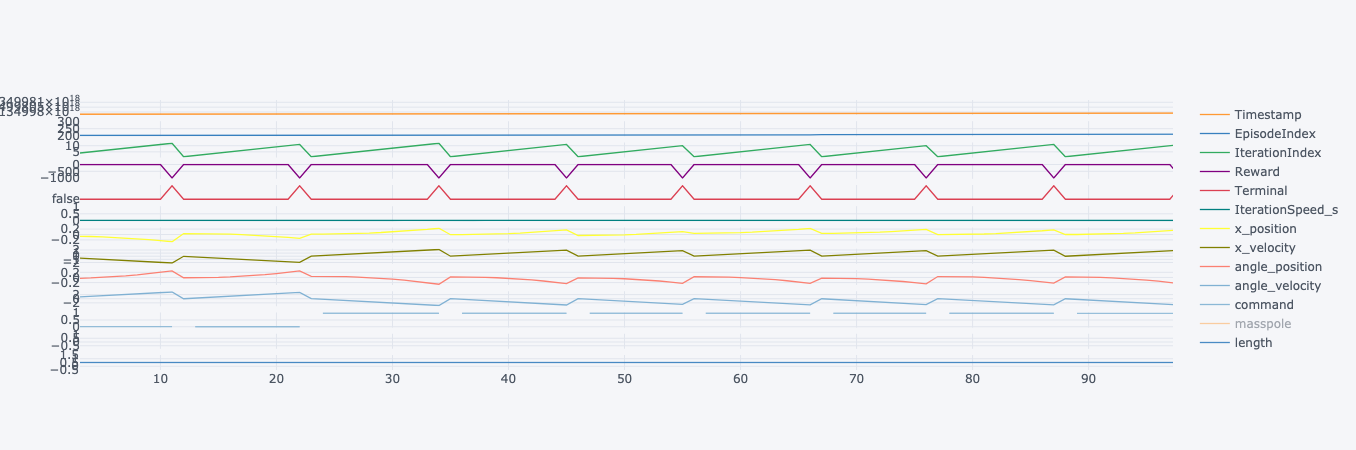

In [13]:
assess_df_cleaned.iplot(
    subplots=True,
    shared_xaxes=True,
    #title = 'Title'
    )


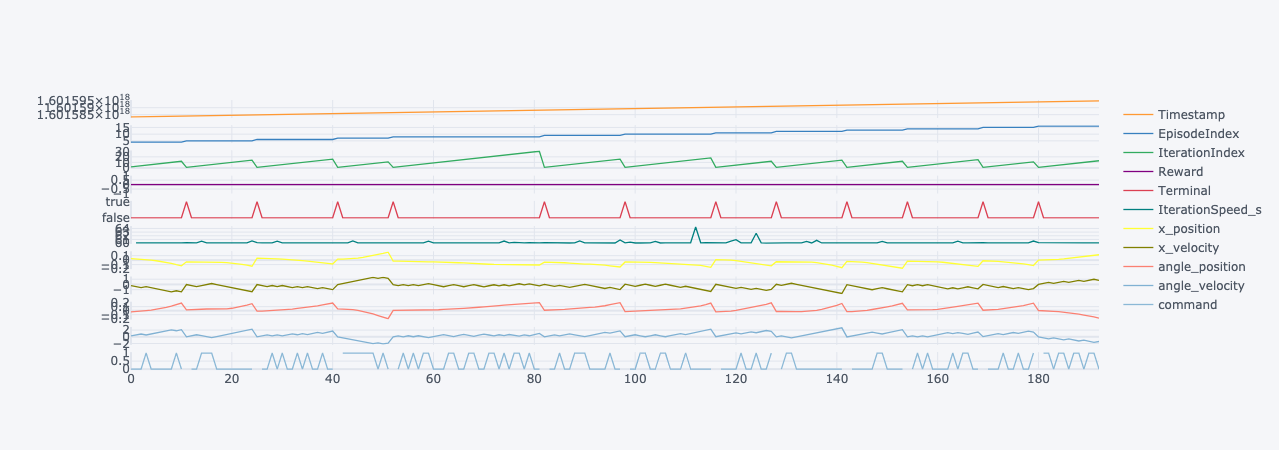

In [74]:
df.iplot(
    subplots=True,
    shared_xaxes=True,
    #title = 'Title'
    )

## Distributions of values 

&lt;AxesSubplot:ylabel=&#39;Frequency&#39;&gt;

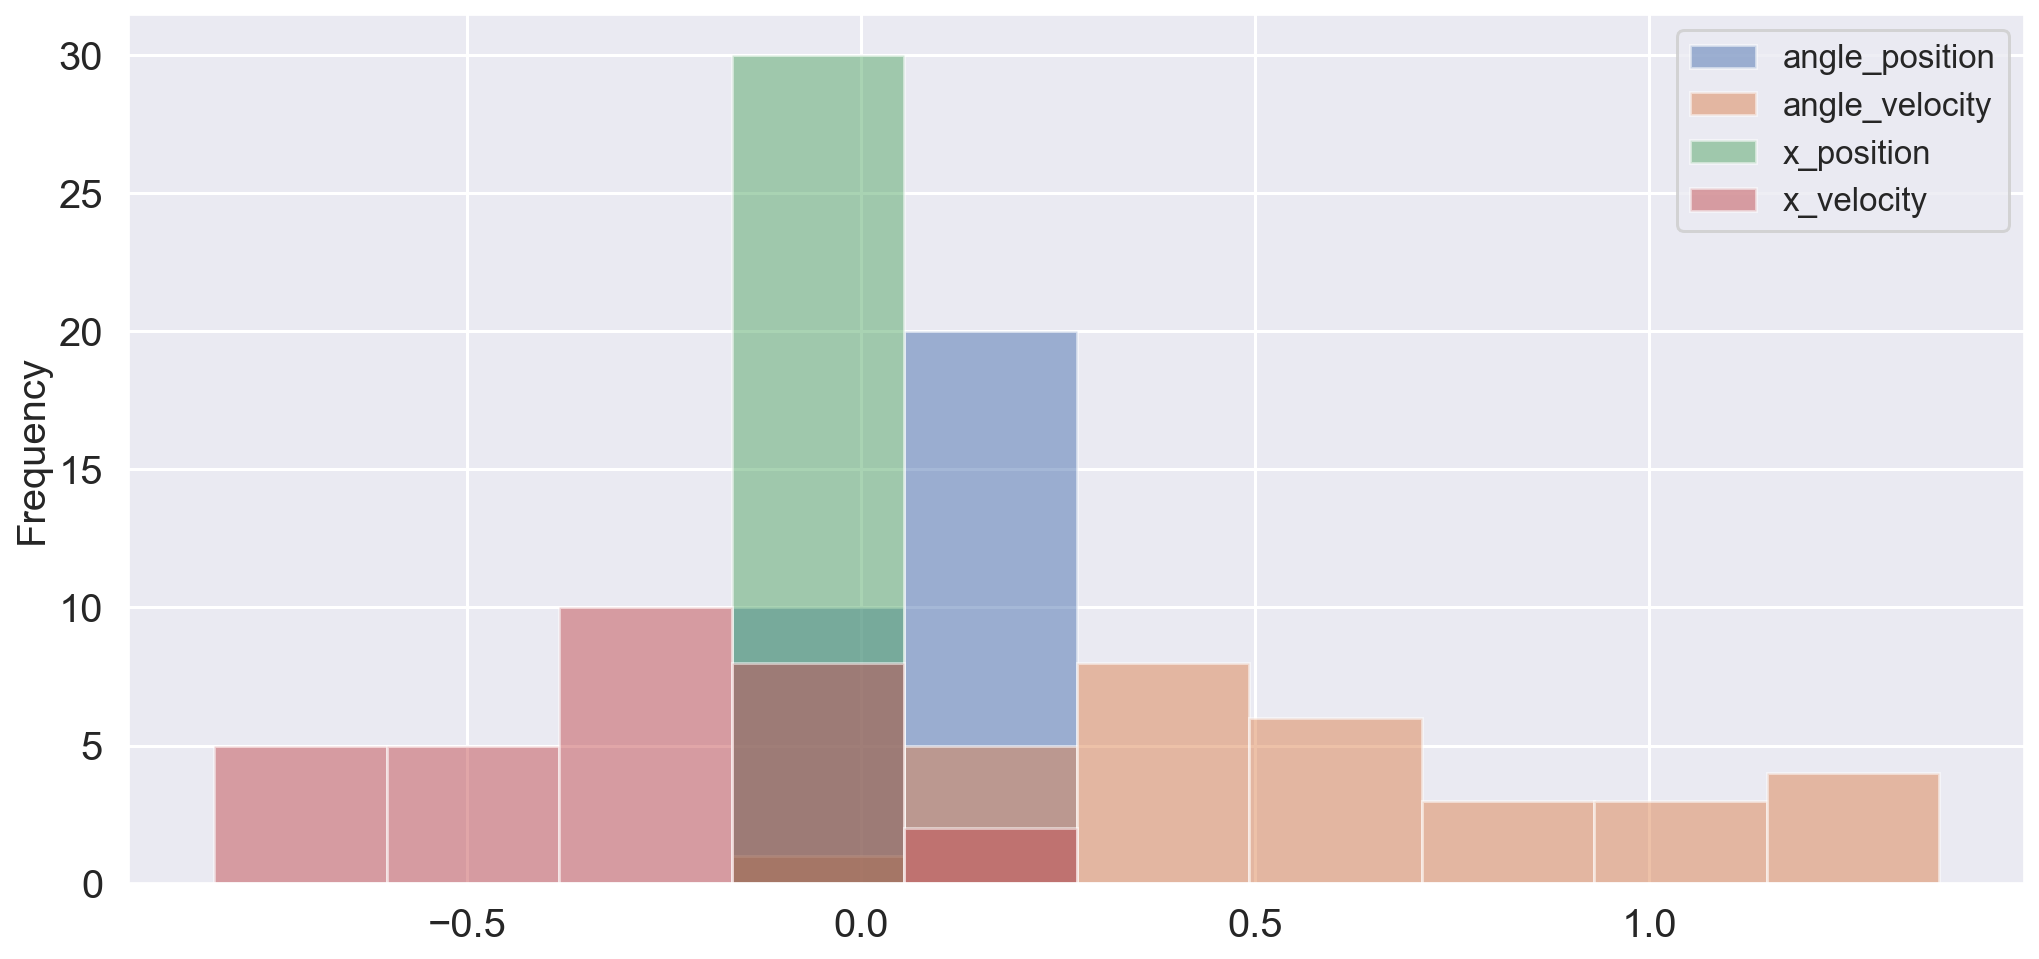

In [75]:
 plot_df = df.pivot_table(
     index=['IterationIndex'], 
     values= ['angle_position','angle_velocity', 'x_position','x_velocity']
    )
plot_df.plot(kind='hist',alpha=0.5)

## Iteration speed

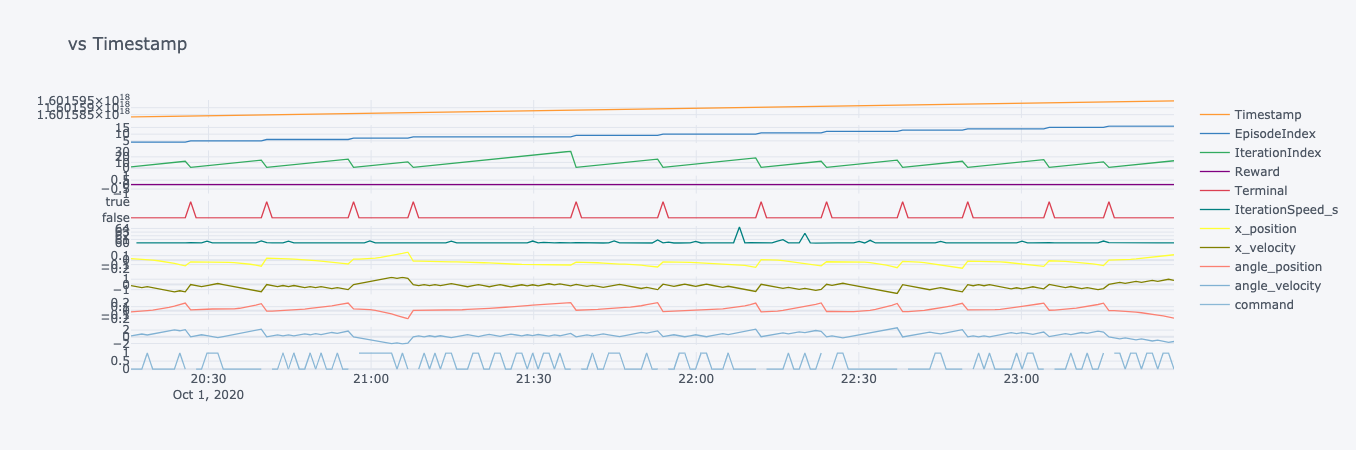

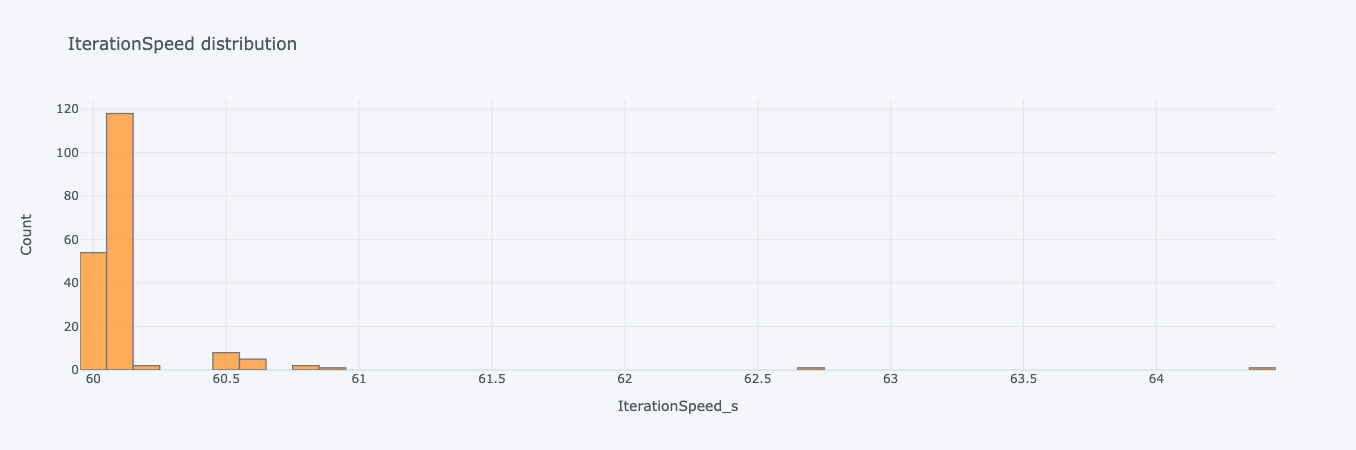

In [76]:
plotdf = df
plotdf.index= df['Timestamp']
plotdf.iplot(
    subplots=True,
    shared_xaxes=True,
    title = 'vs Timestamp'
    )

plotdf['IterationSpeed_s'].iplot(
    title = 'IterationSpeed distribution',
    kind='hist',
    xTitle='IterationSpeed_s',
    yTitle='Count'
    )

## State trajectory for multiple episodes
TODO: Consider plotting considering vs SimConfig

In [77]:
plot_df = df.pivot(
    index=['IterationIndex'],
    columns = ['EpisodeIndex'],
    values = ['x_position', 'angle_position','x_velocity','angle_velocity'])
plot_df.head(10)

x_position                                                    \
EpisodeIndex         4.0       5.0       6.0       7.0       8.0       9.0    
IterationIndex                                                                
1.0                   NaN -0.037274  0.046273  0.022657 -0.022950 -0.043859   
2.0              0.032140 -0.037687  0.045994  0.022228 -0.023877 -0.043610   
3.0              0.027562 -0.042008  0.041818  0.025688 -0.028709 -0.047266   
4.0              0.019091 -0.050236  0.033742  0.033037 -0.029641 -0.054828   
5.0              0.006725 -0.054569  0.029571  0.044279 -0.034480 -0.058492   
6.0             -0.001734 -0.055010  0.021497  0.059416 -0.035420 -0.066065   
7.0             -0.014097 -0.051561  0.017323  0.078455 -0.040269 -0.077550   
8.0             -0.030364 -0.052026  0.009241  0.101399 -0.041222 -0.085145   
9.0             -0.050542 -0.056404 -0.002751  0.128256 -0.038279 -0.088855   
10.0            -0.074634 -0.064695 -0.010851  0.151229 -0.039248 -0.088685   

                                                        ... angle_velocity  \
EpisodeIndex        10.0      11.0      12.0      13.0  ...           7.0    
IterationIndex                                          ...                  
1.0            -0.040965  0.009916 -0.036944 -0.028784  ...      -0.038370   
2.0            -0.040187  0.010587 -0.036304 -0.029604  ...      -0.317125   
3.0            -0.043305  0.007363 -0.039560 -0.034320  ...      -0.596139   
4.0            -0.050317  0.000245 -0.038908 -0.042930  ...      -0.877248   
5.0            -0.053423 -0.010769 -0.034349 -0.055438  ...      -1.162245   
6.0            -0.052624 -0.025683 -0.033688 -0.071845  ...      -1.452853   
7.0            -0.055728 -0.036697 -0.036922 -0.092157  ...      -1.750691   
8.0            -0.062734 -0.051621 -0.044053 -0.108573  ...      -2.057233   
9.0            -0.065840 -0.070459 -0.055080 -0.121103  ...      -1.790573   
10.0           -0.065049 -0.085414 -0.070008 -0.137555  ...      -2.118520   

                                                                            \
EpisodeIndex        8.0       9.0       10.0      11.0      12.0      13.0   
IterationIndex                                                               
1.0            -0.003948 -0.028988  0.032628  0.021706 -0.013488 -0.040993   
2.0             0.291540  0.267036  0.317386  0.305388  0.272618  0.243972   
3.0             0.001662  0.562878  0.602359  0.589215 -0.026581  0.528673   
4.0             0.298941  0.275090  0.304125  0.875026 -0.324095  0.814957   
5.0             0.010936  0.576064  0.009635  1.164616 -0.036491  1.104630   
6.0             0.310076  0.878705  0.302424  0.874362  0.249023  1.399431   
7.0             0.024062  0.600072  0.595274  1.176630  0.534305  1.115912   
8.0            -0.259944  0.327299  0.304670  1.484112  0.821197  0.841594   
9.0             0.041314  0.058592  0.017873  1.214764  1.111506  1.158088   
10.0            0.340979  0.375351  0.318207  1.537508  1.406970  1.479265   

                                              
EpisodeIndex        14.0      15.0      16.0  
IterationIndex                                
1.0            -0.028558  0.042154 -0.026244  
2.0             0.269648  0.338287 -0.317769  
3.0            -0.017593  0.634681 -0.609461  
4.0             0.282102  0.933165 -0.317793  
5.0            -0.003516  0.650480 -0.615294  
6.0             0.297802  0.958468 -0.914751  
7.0             0.599095  1.270252 -0.632966  
8.0             0.902190  1.004382 -0.941669  
9.0             1.208866  1.328811 -1.254054  
10.0            0.936804  1.658557 -0.988770  

[10 rows x 52 columns]

## Retrieving Logs for Assessment

Here is an example of extracting logs that were generated during assessment. We modify our above query by including the `AssessmentId_g` column, and filter only for those that were not empty, which should be when the simulators were being used for assessment:

In [17]:
%%kql
let _number_of_rows = 1000;
let _brain_name = "cartpole-assessment-test";
let _brain_version = 2;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(30d)
  | where AssessmentId_g != ""
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
//   | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      AssessmentName = AssessmentName_s,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by AssessmentName, SessionIndex, EpisodeIndex asc, IterationIndex asc

<IPython.core.display.Javascript object>

Timestamp,AssessmentName,SessionIndex,EpisodeIndex,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
2021-02-16 18:35:22.589000+00:00,cartpole-assessment-test20210216T063338,1133348487_10.244.67.141,1,1,Unspecified,cartpole-assessment-test,2,"{'x_position': -0.002499768166938532, 'x_velocity': 0.0402359742898271, 'angle_position': -0.04233017792946045, 'angle_velocity': 0.0157880678497007}",None,"{'length': 0.99, 'masspole': 0.25}",0,-989,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}",Unspecified,Interrupted
2021-02-16 18:35:22.932000+00:00,cartpole-assessment-test20210216T063338,1133348487_10.244.67.141,1,2,Unspecified,cartpole-assessment-test,2,"{'x_position': -0.0016950486811419898, 'x_velocity': 0.2299291808708752, 'angle_position': -0.042014416572466434, 'angle_velocity': -0.15761802302917827}",{'command': 1},"{'length': 0.99, 'masspole': 0.25}",0,-989,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}",Unspecified,Interrupted
2021-02-16 18:35:22.942000+00:00,cartpole-assessment-test20210216T063338,1133348487_10.244.67.141,1,3,Unspecified,cartpole-assessment-test,2,"{'x_position': 0.0029035349362755143, 'x_velocity': 0.4196190942347193, 'angle_position': -0.04516677703305, 'angle_velocity': -0.3309699654361835}",{'command': 1},"{'length': 0.99, 'masspole': 0.25}",0,-989,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}",Unspecified,Interrupted
2021-02-16 18:35:22.951000+00:00,cartpole-assessment-test20210216T063338,1133348487_10.244.67.141,1,4,Unspecified,cartpole-assessment-test,2,"{'x_position': 0.0112959168209699, 'x_velocity': 0.6093283383844046, 'angle_position': -0.05178617634177367, 'angle_velocity': -0.5048495858180934}",{'command': 1},"{'length': 0.99, 'masspole': 0.25}",0,-989,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}",Unspecified,Interrupted
2021-02-16 18:35:22.960000+00:00,cartpole-assessment-test20210216T063338,1133348487_10.244.67.141,1,5,Unspecified,cartpole-assessment-test,2,"{'x_position': 0.023482483588657992, 'x_velocity': 0.7990774763240638, 'angle_position': -0.06188316805813553, 'angle_velocity': -0.6798290588361736}",{'command': 1},"{'length': 0.99, 'masspole': 0.25}",0,-989,False,0,"{'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}",Unspecified,Interrupted


[{'Timestamp': datetime.datetime(2021, 2, 16, 18, 35, 22, 589000, tzinfo=tzutc()), 'AssessmentName': 'cartpole-assessment-test20210216T063338', 'SessionIndex': '1133348487_10.244.67.141', 'EpisodeIndex': 1, 'IterationIndex': 1, 'EpisodeType_s': 'Unspecified', 'BrainName': 'cartpole-assessment-test', 'BrainVersion': 2, 'SimState': {'x_position': -0.002499768166938532, 'x_velocity': 0.0402359742898271, 'angle_position': -0.04233017792946045, 'angle_velocity': 0.0157880678497007}, 'SimAction': None, 'SimConfig': {'length': 0.99, 'masspole': 0.25}, 'Reward': 0, 'CumulativeReward': -989, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}, 'EpisodeType': 'Unspecified', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 2, 16, 18, 35, 22, 932000, tzinfo=tzutc()), 'AssessmentName': 'cartpole-assessment-test20210216T063338', 'SessionIndex': '1133348487_10.244.67.141', 'EpisodeIndex': 1, 'IterationIndex': 2, 'EpisodeType_s': 'Unspecified', 'BrainName': 'cartpole-assessment-test', 'BrainVersion': 2, 'SimState': {'x_position': -0.0016950486811419898, 'x_velocity': 0.2299291808708752, 'angle_position': -0.042014416572466434, 'angle_velocity': -0.15761802302917827}, 'SimAction': {'command': 1}, 'SimConfig': {'length': 0.99, 'masspole': 0.25}, 'Reward': 0, 'CumulativeReward': -989, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}, 'EpisodeType': 'Unspecified', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 2, 16, 18, 35, 22, 942000, tzinfo=tzutc()), 'AssessmentName': 'cartpole-assessment-test20210216T063338', 'SessionIndex': '1133348487_10.244.67.141', 'EpisodeIndex': 1, 'IterationIndex': 3, 'EpisodeType_s': 'Unspecified', 'BrainName': 'cartpole-assessment-test', 'BrainVersion': 2, 'SimState': {'x_position': 0.0029035349362755143, 'x_velocity': 0.4196190942347193, 'angle_position': -0.04516677703305, 'angle_velocity': -0.3309699654361835}, 'SimAction': {'command': 1}, 'SimConfig': {'length': 0.99, 'masspole': 0.25}, 'Reward': 0, 'CumulativeReward': -989, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}, 'EpisodeType': 'Unspecified', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 2, 16, 18, 35, 22, 951000, tzinfo=tzutc()), 'AssessmentName': 'cartpole-assessment-test20210216T063338', 'SessionIndex': '1133348487_10.244.67.141', 'EpisodeIndex': 1, 'IterationIndex': 4, 'EpisodeType_s': 'Unspecified', 'BrainName': 'cartpole-assessment-test', 'BrainVersion': 2, 'SimState': {'x_position': 0.0112959168209699, 'x_velocity': 0.6093283383844046, 'angle_position': -0.05178617634177367, 'angle_velocity': -0.5048495858180934}, 'SimAction': {'command': 1}, 'SimConfig': {'length': 0.99, 'masspole': 0.25}, 'Reward': 0, 'CumulativeReward': -989, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'reachGoalMetrics': [], 'driveGoalMetrics': [], 'avoidGoalMetrics': {'goal_satisfaction_rate': 1, 'goal_index': 1, 'success_per_dimension': [1], 'success': 1}}, 'EpisodeType': 'Unspecified', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 2, 16, 18, 35, 22, 960000, tzinfo=tzutc()), 'AssessmentName': 'cartpole-assessment-test20210216T063338', 'SessionIndex': '1133348487_10.244.67.141', 'EpisodeIndex': 1, 'IterationIndex': 5, 'EpisodeType_s': 'Unspecified', 'BrainName': 'cartpole-assessment-test', 'BrainVersion': 2, 'SimState': {'x_position': 0.023482483588657992, 'x_velocity': 0.7990774763240638, 'angle_position': -0.06188316805813553, 'angle_velocity': -0.6798290588361736}, 'SimAction': {'command'

In [18]:
assess_df = _kql_raw_result_.to_dataframe()

In [19]:
assess_df.describe()

,EpisodeIndex,IterationIndex,BrainVersion,Reward,CumulativeReward,LessonIndex
count,46.000000,46.000000,46.0,46.000000,46.000000,46.0
mean,2.826087,5.347826,2.0,-107.804348,-991.304348,0.0
std,1.465217,3.056631,0.0,312.116689,2.064187,0.0
min,1.000000,1.000000,2.0,-995.000000,-995.000000,0.0
25%,1.250000,3.000000,2.0,0.000000,-993.000000,0.0
50%,3.000000,5.000000,2.0,0.000000,-991.000000,0.0
75%,4.000000,7.750000,2.0,0.000000,-989.250000,0.0
max,5.000000,12.000000,2.0,0.000000,-989.000000,0.0
